In [40]:
import NN_Module as nnm
import torch
import numpy as np
import numpy.ma as ma
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import math
import time
import pandas as pd
from pandas import read_csv
import argparse
from matplotlib.backends.backend_pdf import PdfPages

In [41]:
# Functions
def evaluate(inputs):
    # Assumes model uses square and cross terms as well as standardization
    # Currently only uses a slice of inputs_all
    all_shape = list(inputs.shape) # The shape of the final input tensor, including the square and cross terms
    all_shape[-1] = 152
    cross_shape = list(inputs.shape) # The shape of the input cross terms tensor
    cross_shape[-1] = 120
    inputs_all = torch.zeros(all_shape).cuda()
    squares = inputs**2
    cross_terms = torch.zeros(cross_shape).cuda()
    idx = 0
    for i in range(16):
        for j in range(i):
            cross_terms[...,idx] = inputs[...,i] * inputs[...,j]
            idx += 1
    inputs_all[...,0:16] = inputs
    inputs_all[...,16:32] = squares
    inputs_all[...,32:152] = cross_terms
    std_inputs = nnm.affine_transform(inputs_all, input_stats)
    std_outputs = model(std_inputs)
    outputs = nnm.affine_untransform(std_outputs, output_stats)
    
    return outputs

In [42]:
out_file = '3169_0'

In [43]:
names = {}
names['cQei'] = 0
names['cQl3i'] = 1
names['cQlMi'] = 2
names['cbW'] = 3
names['cpQ3'] = 4
names['cpQM'] = 5
names['cpt'] = 6
names['cptb'] = 7
names['ctG'] = 8
names['ctW'] = 9
names['ctZ'] = 10
names['ctei'] = 11
names['ctlSi'] = 12
names['ctlTi'] = 13
names['ctli'] = 14
names['ctp'] = 15

WC_to_analyze_1 = ['cpQ3', 'cpQM', 'cpt', 'cptb', 'cQei', 'ctei', 'ctli', 'ctW'] # The first of the two WCs to graph
WC_to_analyze_2 = ['cbW', 'ctG', 'ctp', 'cQl3i', 'cQlMi', 'ctlTi', 'ctlSi', 'ctZ'] # The second of the two WCs to graph

batch_size = 4096
epochs = 100
random_starting_points = 50 # The number of random starting points to do gradient descent on for each scanned value

In [44]:
save_dict = torch.load(f'./{out_file}_model+.pt')
best_model_state = save_dict['model']
parameters_save = save_dict['parameters']
input_stats = save_dict['input_stats']
output_stats = save_dict['output_stats']

In [45]:
# Check to make sure we're on cuda
input_stats[0].device

device(type='cuda', index=0)

In [46]:
torch.cuda.memory_allocated() / 1e9

5.530527232

In [47]:
parameters_save

{'N': 152,
 'train_size': 6619234,
 'test_size': 66860,
 'hidden_nodes': 700,
 'hidden_layers': 2,
 'batch_size': 512,
 'n_epochs': 195,
 'learning_rate': 0.0001,
 'lr_red_factor': 0.2,
 'lr_red_patience': 20.0,
 'lr_red_threshold': 1e-06,
 'weight_decay': 0.0,
 'accu_out_resolution': 100,
 'out_residual_resolution': 100}

In [48]:
model = nnm.create_model(152, 1, parameters_save) # Hard-coded for the inclusion of square and cross terms
model.load_state_dict(best_model_state)
model.eval()

Sequential(
  (0): Linear(in_features=152, out_features=700, bias=True)
  (1): ReLU()
  (2): Linear(in_features=700, out_features=700, bias=True)
  (3): ReLU()
  (4): Linear(in_features=700, out_features=700, bias=True)
  (5): ReLU()
  (6): Linear(in_features=700, out_features=1, bias=True)
)

In [49]:
actual_frozen_2D_data = {}
actual_profiled_2D_data = {}
model_frozen_2D_data = {}
model_profiled_2D_data = {}

In [50]:
# Just test the first graph
num = 0

In [51]:
# actual frozen data
WC1 = WC_to_analyze_1[num]
WC2 = WC_to_analyze_2[num]
loaded = np.load(f'likelihood_{WC1}_{WC2}.npz')
actual_frozen_2D_data[str(num)] = {WC1: loaded[WC1], WC2: loaded[WC2], 'deltaNLL': loaded['deltaNLL']}
actual_frozen_2D_data[str(num)]['deltaNLL'] -= actual_frozen_2D_data[str(num)]['deltaNLL'].min()
actual_frozen_2D_data[str(num)]['deltaNLL'] *= 2

In [52]:
# actual profiled data
WC1 = WC_to_analyze_1[num]
WC2 = WC_to_analyze_2[num]
loaded = np.load(f'likelihood_profiled_{WC1}_{WC2}.npz')
inputs = np.zeros((loaded['deltaNLL'].shape[0], random_starting_points, 16))
for key2 in names.keys():
    inputs[...,names[key2]] = loaded[key2][:,np.newaxis] # broadcast into the new axis of random starting points
actual_profiled_2D_data[str(num)] = {'inputs': inputs, 'deltaNLL': loaded['deltaNLL']}
actual_profiled_2D_data[str(num)]['deltaNLL'] -= actual_profiled_2D_data[str(num)]['deltaNLL'].min()
actual_profiled_2D_data[str(num)]['deltaNLL'] *= 2

In [53]:
# model frozen data
inputs_y = actual_frozen_2D_data[str(num)][WC_to_analyze_1[num]]
inputs_x = actual_frozen_2D_data[str(num)][WC_to_analyze_2[num]]
num_inputs = inputs_y.shape[0]
inputs_all = np.zeros((num_inputs, 152))
inputs_all[:,names[WC_to_analyze_1[num]]] = inputs_y
inputs_all[:,names[WC_to_analyze_2[num]]] = inputs_x
inputs_all[:,16:32] = inputs_all[:,0:16]**2
idx = 32
for i in range(16):
    for j in range(i):
        inputs_all[:,idx] = inputs_all[:,i] * inputs_all[:,j]
        idx += 1
std_inputs = nnm.affine_transform(torch.from_numpy(inputs_all).float().cuda(), input_stats)
std_outputs = torch.full((num_inputs, 1), 100.).cuda() # fill outputs with 100. as a default (decimal to force dtype=float not int)
inputMiniBatches = torch.split(std_inputs, batch_size)
batch_idx = 0
for minibatch in range(len(inputMiniBatches)):
    batch_outputs = model(inputMiniBatches[minibatch])
    std_outputs[batch_idx: batch_idx + batch_outputs.shape[0]] = batch_outputs
    batch_idx += batch_outputs.shape[0]
outputs = nnm.affine_untransform(std_outputs, output_stats).cpu().detach().numpy().flatten()
outputs -= outputs.min()
outputs *= 2
model_frozen_2D_data[str(num)] = {WC_to_analyze_1[num]: inputs_all[:,names[WC_to_analyze_1[num]]], WC_to_analyze_2[num]: inputs_all[:,names[WC_to_analyze_2[num]]], 'deltaNLL': outputs}

Starting 0/22 minibatches.
cpQ3 cbW batch number: 0
tensor([[[ 1.5067e-01,  3.0426e+00,  5.5110e-01,  ...,  3.7215e-03,
           1.6550e-01,  2.3934e+01]],

        [[ 7.6141e-01, -7.9723e-01, -1.4727e-01,  ...,  7.2535e-02,
           7.6233e-02, -1.2855e+01]],

        [[ 6.7850e-01, -7.3838e-01, -1.0747e-01,  ...,  4.8032e-02,
           8.6761e-02, -1.2890e+01]],

        ...,

        [[ 5.1259e-01, -3.9659e-01, -6.5059e-02,  ...,  2.2224e-02,
           8.1966e-02, -7.4699e+00]],

        [[ 4.7141e-01, -3.6154e-01, -4.5486e-02,  ...,  2.9927e-02,
           1.3760e-01, -7.6395e+00]],

        [[ 5.1116e-01, -1.5079e-01, -8.1037e-02,  ...,  2.6438e-02,
           2.0413e-01, -7.6103e+00]]], device='cuda:0', dtype=torch.float64)
Starting 1/22 minibatches.
cpQ3 cbW batch number: 1
tensor([[[ 4.6991e-01, -2.9921e-01, -1.4417e-01,  ...,  3.1773e-02,
           1.2192e-01, -7.3857e+00]],

        [[ 4.9365e-01, -2.5797e-01, -7.3350e-02,  ...,  3.5514e-02,
           1.2809e-01, -7.3

Starting 12/22 minibatches.
cpQ3 cbW batch number: 12
tensor([[[ 3.9199e-02, -3.2422e+00,  4.3799e-01,  ..., -5.6824e-03,
           3.6519e-01,  2.1833e+01]],

        [[ 1.7118e-01, -3.2940e+00,  3.3605e-01,  ..., -1.2718e-02,
           4.5870e-01,  2.1983e+01]],

        [[ 1.1219e-01, -3.3796e+00,  3.1487e-01,  ...,  3.5552e-03,
           3.8891e-01,  2.1961e+01]],

        ...,

        [[ 7.2605e-02, -5.1636e+00,  6.0748e-01,  ..., -1.3106e-03,
           2.8615e-01,  2.2860e+01]],

        [[ 1.3018e-01, -5.6452e+00,  5.4747e-01,  ..., -1.4187e-03,
           3.2218e-01,  2.2266e+01]],

        [[ 4.7546e-02, -5.9292e+00,  3.5696e-01,  ..., -3.0589e-02,
           3.3748e-01,  2.2626e+01]]], device='cuda:0', dtype=torch.float64)
Starting 13/22 minibatches.
cpQ3 cbW batch number: 13
tensor([[[ 1.1989e-01, -5.6278e+00,  4.3173e-01,  ..., -1.5051e-02,
           3.8661e-01,  2.2870e+01]],

        [[ 1.5338e-01, -5.7742e+00,  5.2168e-01,  ...,  1.5999e-03,
           3.7823e-01, 

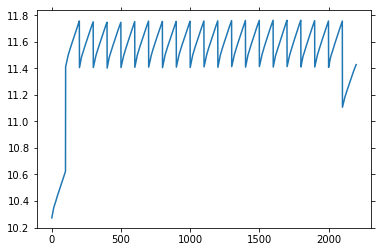

In [54]:
# model profiled data
torch.autograd.set_detect_anomaly(True)
inputs_old = actual_profiled_2D_data[str(num)]['inputs']
num_inputs = inputs.shape[0]
model_profiled_2D_data[str(num)] = {WC_to_analyze_1[num]: inputs_old[..., 0, names[WC_to_analyze_1[num]]], WC_to_analyze_2[num]: inputs[..., 0, names[WC_to_analyze_2[num]]]}
inputs = (np.random.random_sample(inputs_old.shape) - 0.5) * 40
inputs[...,names[WC_to_analyze_1[num]]] = inputs_old[...,names[WC_to_analyze_1[num]]] # copy over the WC being scanned, while leaving the other 15 randomized
inputs[...,names[WC_to_analyze_2[num]]] = inputs_old[...,names[WC_to_analyze_2[num]]] # copy over the WC being scanned, while leaving the other 15 randomized
inputs = torch.from_numpy(inputs).cuda()
inputs.requires_grad = True

outputs = torch.full((num_inputs, 1), 100.).cuda() # fill outputs with 100. as a default (decimal to force dtype=float not int)
inputMiniBatches = torch.split(inputs, batch_size)
batch_idx = 0

start_time = time.perf_counter()

# Memory debugging info
memory_fig, memory_ax = plt.subplots()
memory_count = 0
memory_count_arr = np.full((len(inputMiniBatches)*epochs), np.NaN)
memory_vals = np.full((len(inputMiniBatches)*epochs), np.NaN)

for minibatch in range(len(inputMiniBatches)):
    optimizer = torch.optim.Adam([inputs],lr=1e-0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=5, threshold=1e-6)
    batch_inputs = inputMiniBatches[minibatch]
    min_outputs = evaluate(batch_inputs) # The outputs of the random starting points, to be updated every epoch
    min_WCs = batch_inputs.detach().clone() # A snapshot of the WCs of all the points to scan
    optimizer.zero_grad()
    print (f'Starting {minibatch}/{len(inputMiniBatches)} minibatches.')
    for epoch in range(epochs):
        #print (f'Starting {epoch}/{epochs} epochs of {minibatch}/{len(inputMiniBatches)} minibatches.')
        
        batch_outputs = evaluate(batch_inputs)
        batch_outputs_cp = batch_outputs.detach().clone()
        batch_outputs_sum = torch.sum(torch.log(batch_outputs + 10)) # Optimize the sum of outputs
        idx_to_update = torch.where(batch_outputs_cp < min_outputs)[0]
        min_outputs[idx_to_update] = batch_outputs_cp[idx_to_update]
        min_WCs[idx_to_update] = batch_inputs.detach().clone()[idx_to_update]
        optimizer.zero_grad()
        batch_outputs_sum.backward()
        #print (torch.count_nonzero(inputs.grad))
        #print (inputs.grad)
        #print (inputs.grad[1500,31,6])
        #print (f'Sum of minibatch outputs: {batch_outputs_sum}')
        #print (f'Output of a random point: {batch_outputs[500,0,0]}')
        inputs.grad[...,names[WC_to_analyze_1[num]]] = 0
        inputs.grad[...,names[WC_to_analyze_2[num]]] = 0
        optimizer.step()
        #scheduler.step(output)
        
        # Memory debugging info
        memory_count_arr[memory_count] = memory_count
        memory_vals[memory_count] = torch.cuda.memory_allocated()/1e9
        memory_ax.cla()
        memory_ax.plot(memory_count_arr, memory_vals)
        memory_count += 1
        
    (min_outputs_scanned, min_starting_point_indicies) = torch.min(min_outputs, -2) # Get the best all starting points
    
    # Make the index tensor suitable for gathering the min_WCs
    min_starting_point_indicies = min_starting_point_indicies.unsqueeze(-2)
    min_starting_point_indicies_shape = list(min_starting_point_indicies.shape)
    min_starting_point_indicies_shape[-1] = 16
    min_starting_point_indicies = min_starting_point_indicies.expand(min_starting_point_indicies_shape) # Warning: don't perform in-place operations on this since expand() does not allocate new memory

    min_WCs_scanned = torch.gather(min_WCs, -2, min_starting_point_indicies) # Get the WCs corresponding to the best-performing starting points
    outputs[batch_idx: batch_idx + batch_outputs.shape[0]] = min_outputs_scanned.detach().clone() # detach from graph to delete obsolete graphs from memory! This was the culprit causing the memory leak
    print (WC_to_analyze_1[num] + ' ' + WC_to_analyze_2[num] + ' ' + 'batch number: ' + str(minibatch))
    print (min_WCs_scanned)
    batch_idx += batch_outputs.shape[0]
print ('Profiling done!')
print (f'Time used: {time.perf_counter() - start_time} seconds.')
outputs = outputs.cpu().detach().numpy().flatten()
outputs -= outputs.min()
outputs *= 2
model_profiled_2D_data[str(num)]['deltaNLL'] = outputs

In [55]:
frozen_graphs = {}
profiled_graphs = {}

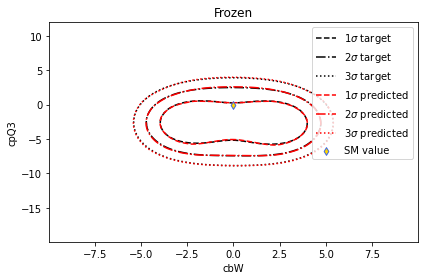

In [56]:
# frozen graphs
frozen_graphs[str(num)] = plt.subplots()
actual_contour = frozen_graphs[str(num)][1].tricontour(actual_frozen_2D_data[str(num)][WC_to_analyze_2[num]], actual_frozen_2D_data[str(num)][WC_to_analyze_1[num]], actual_frozen_2D_data[str(num)]['deltaNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
model_contour = frozen_graphs[str(num)][1].tricontour(model_frozen_2D_data[str(num)][WC_to_analyze_2[num]], model_frozen_2D_data[str(num)][WC_to_analyze_1[num]], model_frozen_2D_data[str(num)]['deltaNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
SM_value = frozen_graphs[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
frozen_graphs[str(num)][1].legend(actual_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
frozen_graphs[str(num)][1].set_xlabel(WC_to_analyze_2[num])
frozen_graphs[str(num)][1].set_ylabel(WC_to_analyze_1[num])
frozen_graphs[str(num)][1].set_title('Frozen')
frozen_graphs[str(num)][0].tight_layout()

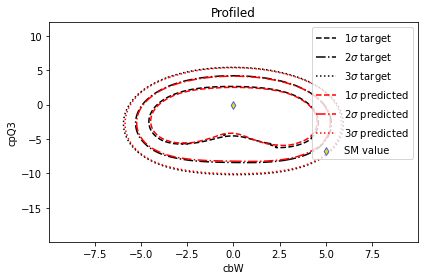

In [57]:
# profiled graphs
profiled_graphs[str(num)] = plt.subplots()
actual_contour = profiled_graphs[str(num)][1].tricontour(model_profiled_2D_data[str(num)][WC_to_analyze_2[num]], model_profiled_2D_data[str(num)][WC_to_analyze_1[num]], actual_profiled_2D_data[str(num)]['deltaNLL'], colors='k', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
model_contour = profiled_graphs[str(num)][1].tricontour(model_profiled_2D_data[str(num)][WC_to_analyze_2[num]], model_profiled_2D_data[str(num)][WC_to_analyze_1[num]], model_profiled_2D_data[str(num)]['deltaNLL'], colors='r', linestyles=['dashed', 'dashdot', 'dotted'], levels=[2.30, 6.18, 11.83]) # 1, 2, and 3 sigmas
SM_value = profiled_graphs[str(num)][1].scatter(0, 0, marker='d', c='gold', ec='royalblue', s=30, linewidths=1, zorder=10)
profiled_graphs[str(num)][1].legend(actual_contour.collections+model_contour.collections+[SM_value], ['$1\sigma$ target', '$2\sigma$ target', '$3\sigma$ target', '$1\sigma$ predicted', '$2\sigma$ predicted', '$3\sigma$ predicted', 'SM value'])
profiled_graphs[str(num)][1].set_xlabel(WC_to_analyze_2[num])
profiled_graphs[str(num)][1].set_ylabel(WC_to_analyze_1[num])
profiled_graphs[str(num)][1].set_title('Profiled')
profiled_graphs[str(num)][0].tight_layout()

In [39]:
# Save graphs to pdf
pp = PdfPages(f'{out_file}_validation_2D_with_profiling.pdf')
for key in frozen_graphs.keys():
    pp.savefig(frozen_graphs[key][0])
for key in profiled_graphs.keys():
    pp.savefig(profiled_graphs[key][0])
pp.close()

In [244]:
# Check individual points
idx = 42969
print (model_profiled_2D_data[str(num)]['cpQ3'][idx])
print (model_profiled_2D_data[str(num)]['cbW'][idx])
print (model_profiled_2D_data[str(num)]['deltaNLL'][idx])

-2.559999942779541
3.0333333015441895
0.07707214
